In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
conda install -c conda-forge scikit-plot

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install yfinance
!pip install investpy
!pip install pykrx
!pip install seaborn
!pip install workalendar
!pip install --upgrade finance-datareader
!pip install TA_Lib-0.4.19-cp38-cp38-win_amd64.whl
!pip install -U finance-datareader
!pip install keras

You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


Processing c:\users\user\downloads\ta_lib-0.4.19-cp38-cp38-win_amd64.whl
TA-Lib is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


In [4]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import yfinance as yf # yahoo finance API    # pip install yfinance
import investpy # investing.com API          # pip install investpy
from pykrx import stock # krx API           # pip instasll pykrx
import talib as ta # 기술적 분석 (보조지표)
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
%matplotlib inline

In [5]:
# 크롤링 start_date, end_date
#start_date='2017-01-05'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : ')
#end_date='2021-01-01'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : ')
#train_date = '2020-01-01'
start_date = '2010-01-01'
end_date = '2021-02-01'
train_date = '2019-03-01'

In [6]:
# 데이터 수집기간 입력
# yahoo finance 양식, ex) yyyy-mm-dd
#start_date = '2018-01-01'
#end_date = '2020-10-13'

# investing.com 양식, ex) dd/mm/yyyy
start_date_ = start_date[8:] + '/' + start_date[5:7] + '/' + start_date[:4]
end_date_ = end_date[8:] + '/' + end_date[5:7] + '/' + end_date[:4]

# krx 양식 ex) yyyymmdd
start_date__ = start_date[0:4] + start_date[5:7] + start_date[8:10]
end_date__ = end_date[0:4] + end_date[5:7] + end_date[8:10]

In [7]:
# 주요 3개국 대비 원 환율

# 달러/원
exchange_rate_usd_ = investpy.get_currency_cross_historical_data(currency_cross='USD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_usd_.columns = ['exchange_rate_usd_Open', 'exchange_rate_usd_High', 'exchange_rate_usd_Low', 'exchange_rate_usd_Close', 'exchange_rate_usd_Currency']
exchange_rate_usd_ = exchange_rate_usd_.drop(['exchange_rate_usd_Open','exchange_rate_usd_High','exchange_rate_usd_Low','exchange_rate_usd_Currency'], axis=1)

# S&P 500
snp_500_ = yf.download("^GSPC", start=start_date, end=end_date)
snp_500_.columns = ['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Close','snp_500_Adj Close','snp_500_Volume']
snp_500_ = snp_500_.drop(['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Adj Close','snp_500_Volume'], axis=1)

# NASDAQ
nasdaq_ = yf.download("^IXIC", start=start_date, end=end_date)
nasdaq_.columns = ['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Close','nasdaq_Adj Close','nasdaq_Volume']
nasdaq_ = nasdaq_.drop(['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Adj Close','nasdaq_Volume'], axis=1)

# Russell 2000
russell_2000_ = yf.download("^RUT", start=start_date, end=end_date)
russell_2000_.columns = ['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Close','russell_2000_Adj Close','russell_2000_Volume']
russell_2000_ = russell_2000_.drop(['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Adj Close','russell_2000_Volume'], axis=1)

# 삼성 차트 데이터
sam_ = stock.get_market_ohlcv_by_date(start_date__, end_date__, "005930")
sam_.columns = ['Open','High','Low','Close','Volume']
model_samsung = sam_.copy()

# 3) MACD 이동평균수렴확산 (단기(EMA12)와 장기(EMA26) EMA로 모멘텀을 추정)
macd, macdsignal9, macdhist = ta.MACD(model_samsung.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_samsung['macd'] = macd
model_samsung['macdsignal9'] = macdsignal9
model_samsung['macdhist'] = macdhist

MSCI_KR = fdr.DataReader('156080', start_date,end_date) #MSCI KOREA
MSCI_KR = MSCI_KR.drop(['Open','High','Low', 'Change','Volume'], axis=1) 
MSCI_KR.columns = ['MSCI_KR']

# HANG SENG
hang_seng_ = yf.download("^HSI", start=start_date, end=end_date)
hang_seng_.columns = ['hang_seng_Open','hang_seng_High','hang_seng_Low','hang_seng_Close','hang_seng_Adj Close','hang_seng_Volume']
hang_seng_ = hang_seng_.drop(['hang_seng_Open','hang_seng_High','hang_seng_Low','hang_seng_Adj Close','hang_seng_Volume'], axis=1)

# 미국 국채 수익률 (5년)
treasury_5y_ = yf.download("^FVX", start=start_date, end=end_date)
treasury_5y_.columns = ['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Close','treasury_5y_Adj Close','treasury_5y_Volume']
treasury_5y_ = treasury_5y_.drop(['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Adj Close','treasury_5y_Volume'], axis=1)

# 미국 국채 수익률 (10년)
treasury_10y_ = yf.download("^TNX", start=start_date, end=end_date)
treasury_10y_.columns = ['treasury_10y_Open','treasury_10y_High','treasury_10y_Low','treasury_10y_Close','treasury_10y_Adj Close','treasury_10y_Volume']
treasury_10y_ = treasury_10y_.drop(['treasury_10y_Open','treasury_10y_High','treasury_10y_Low','treasury_10y_Adj Close','treasury_10y_Volume'], axis=1)

# 미국 국채 수익률 (30년)
treasury_30y_ = yf.download("^TYX", start=start_date, end=end_date)
treasury_30y_.columns = ['treasury_30y_Open','treasury_30y_High','treasury_30y_Low','treasury_30y_Close','treasury_30y_Adj Close','treasury_30y_Volume']
treasury_30y_ = treasury_30y_.drop(['treasury_30y_Open','treasury_30y_High','treasury_30y_Low','treasury_30y_Adj Close','treasury_30y_Volume'], axis=1)

# [*에너지*]
# WTI유 시세
crude_oil_ = yf.download("CL=F", start=start_date, end=end_date)
crude_oil_.columns = ['crude_oil_Open','crude_oil_High','crude_oil_Low','crude_oil_Close','crude_oil_Adj Close','crude_oil_Volume']
crude_oil_ = crude_oil_.drop(['crude_oil_Open','crude_oil_High','crude_oil_Low','crude_oil_Adj Close','crude_oil_Volume'], axis=1)

# 브렌트유 시세
brent_crude_oil_ = yf.download("BZ=F", start=start_date, end=end_date)
brent_crude_oil_.columns = ['brent_crude_oil_Open','brent_crude_oil_High','brent_crude_oil_Low','brent_crude_oil_Close','brent_crude_oil_Adj Close','brent_crude_oil_Volume']
brent_crude_oil_ = brent_crude_oil_.drop(['brent_crude_oil_Open','brent_crude_oil_High','brent_crude_oil_Low','brent_crude_oil_Adj Close','brent_crude_oil_Volume'], axis=1)

# SOX 지수 엔비디아(8.9%), 텍사스인스트루먼트(8.6%), 퀄컴(7.7%), 인텔(7.4%) 반도체장비기업 18.52%
SOXX = yf.download("SOXX", start=start_date, end=end_date)
SOXX.columns = ['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Close','SOXX_Adj Close','SOXX_Volume']
SOXX = SOXX.drop(['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Adj Close','SOXX_Volume'], axis=1)

# SMH 인텔(10%), TSMC(10%), 엔비디아(5%)
SMH = yf.download("SMH", start=start_date, end=end_date)
SMH.columns = ['SMH_Open','SMH_High','SMH_Low','SMH_Close','SMH_Adj Close','SMH_Volume']
SMH = SMH.drop(['SMH_Open','SMH_High','SMH_Low','SMH_Close','SMH_Volume'], axis=1)

# SOXL 지수(3배 상승 레버리지) 텍사스인스트루먼트(8.6%) 인텔(8.3%), 퀄컴(7.8%), 엔비디아(7.8%)
SOXL = yf.download("SOXL", start=start_date, end=end_date)
SOXL.columns = ['SOXL_Open','SOXL_High','SOXL_Low','SOXL_Close','SOXL_Adj Close','SOXL_Volume']
SOXL = SOXL.drop(['SOXL_Open','SOXL_High','SOXL_Low','SOXL_Close','SOXL_Volume'], axis=1)

# SOXS 지수(3배 인버스 레버리지) 텍사스인스트루먼트(8.6%) 인텔(8.3%), 퀄컴(7.8%), 엔비디아(7.8%)
SOXS = yf.download("SOXS", start=start_date, end=end_date)
SOXS.columns = ['SOXS_Open','SOXS_High','SOXS_Low','SOXS_Close','SOXS_Adj Close','SOXS_Volume']
SOXS = SOXS.drop(['SOXS_Open','SOXS_High','SOXS_Low','SOXS_Close','SOXS_Volume'], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
model_samsung['US'] = exchange_rate_usd_
model_samsung['SNP500'] = snp_500_
model_samsung['RUSSELL2000'] = russell_2000_
model_samsung['NASDAQ'] = nasdaq_
model_samsung['MSCI_KR'] = MSCI_KR
model_samsung['SOXX'] = SOXX
model_samsung['SMH'] = SMH
model_samsung['SOXL'] = SOXL
model_samsung['SOXS'] = SOXS
model_samsung['TREASURY_5Y']=treasury_5y_
model_samsung['TREASURY_10Y']=treasury_10y_
model_samsung['TREASURY_30Y']=treasury_30y_
#model_samsung['crude_oil'] = crude_oil_
#model_samsung['brent_crude_oil'] = brent_crude_oil_
model_samsung['hang_seng'] = hang_seng_


In [9]:
# samsung 모델
model_samsung['Labeling'] = model_samsung['Close'].shift(-2)
model_samsung = model_samsung.dropna() # 결측치가 있는 행 제거
model_samsung

,Open,High,Low,Close,Volume,macd,macdsignal9,macdhist,US,SNP500,...,MSCI_KR,SOXX,SMH,SOXL,SOXS,TREASURY_5Y,TREASURY_10Y,TREASURY_30Y,hang_seng,Labeling
날짜,,,,,,,,,,,,,,,,,,,,,
2012-04-30,27900,28180,27540,27800,315924,514.972445,386.143049,128.829397,1130.15,1397.910034,...,10609.0,56.110001,30.272848,8.517699,326388.56250,0.811,1.915,3.109,21094.210938,28020.0
2012-05-02,28200,28360,27980,28200,368585,619.193325,432.753104,186.440222,1130.20,1402.310059,...,10718.0,56.549999,30.570417,8.738206,318693.37500,0.819,1.922,3.114,21309.080078,27200.0
2012-05-03,28040,28200,27960,28020,206721,679.432553,482.088994,197.343559,1131.25,1391.569946,...,10655.0,55.139999,29.879015,8.111872,341591.28125,0.817,1.924,3.112,21249.529297,26840.0
2012-05-04,27499,27960,26980,27200,410013,653.472602,516.365715,137.106887,1135.85,1369.099976,...,10578.0,54.029999,29.196362,7.588751,363269.15625,0.784,1.880,3.071,21086.000000,26820.0
2012-05-07,26840,27060,26500,26840,378463,596.968679,532.486308,64.482371,1138.50,1369.579956,...,10377.0,53.869999,29.143854,7.541834,364582.96875,0.782,1.877,3.067,20536.650391,26620.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-22,89000,89700,86800,86800,30861661,3806.686082,4316.350049,-509.663966,1105.41,3841.469971,...,20865.0,417.350006,240.929993,611.849976,13.09000,0.434,1.091,1.857,29447.849609,86700.0
2021-01-25,87000,89900,86300,89400,27258534,3761.486755,4205.377390,-443.890635,1102.58,3855.360107,...,21300.0,417.950012,241.880005,614.479980,13.04000,0.410,1.040,1.798,30159.009766,85600.0
2021-01-26,88800,89200,86500,86700,33178936,3467.823614,4057.866635,-590.043020,1101.02,3849.620117,...,20790.0,411.160004,237.699997,585.830017,13.65000,0.412,1.040,1.802,29391.259766,83700.0


In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [11]:

#4 test, train 나누기
df_scaled = model_samsung.copy()
df_scaled.drop(['Open','High','Low','Volume','macdsignal9', 'macdhist', 'RUSSELL2000', 'NASDAQ', 'MSCI_KR', 'SMH','TREASURY_10Y','TREASURY_30Y'],axis=1,inplace=True)



In [12]:
#df_scaled.drop(['SOXL','hang_seng','Labeling','SNP500','SOXX','US','TREASURY_5Y','macd'],axis=1,inplace=True)
#df_scaled.drop(['SOXL','hang_seng','SNP500','SOXX','US','macd'],axis=1,inplace=True)
df_scaled.drop(['SOXL','hang_seng','macd','Labeling'],axis=1,inplace=True)

In [13]:
df_scaled

,Close,US,SNP500,SOXX,SOXS,TREASURY_5Y
날짜,,,,,,
2012-04-30,27800,1130.15,1397.910034,56.110001,326388.56250,0.811
2012-05-02,28200,1130.20,1402.310059,56.549999,318693.37500,0.819
2012-05-03,28020,1131.25,1391.569946,55.139999,341591.28125,0.817
2012-05-04,27200,1135.85,1369.099976,54.029999,363269.15625,0.784
2012-05-07,26840,1138.50,1369.579956,53.869999,364582.96875,0.782
...,...,...,...,...,...,...
2021-01-22,86800,1105.41,3841.469971,417.350006,13.09000,0.434
2021-01-25,89400,1102.58,3855.360107,417.950012,13.04000,0.410
2021-01-26,86700,1101.02,3849.620117,411.160004,13.65000,0.412


In [14]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(df_scaled)
output = min_max_scaler.transform(df_scaled)
output = pd.DataFrame(output, columns=df_scaled.columns, index=list(df_scaled.index.values))
print(output.head())

               Close        US    SNP500      SOXX      SOXS  TREASURY_5Y
2012-04-30  0.092736  0.457669  0.046510  0.022031  0.650571     0.212781
2012-05-02  0.098478  0.457859  0.048217  0.023199  0.635232     0.215544
2012-05-03  0.095894  0.461845  0.044050  0.019456  0.680875     0.214853
2012-05-04  0.084123  0.479309  0.035331  0.016510  0.724086     0.203454
2012-05-07  0.078955  0.489370  0.035517  0.016085  0.726705     0.202763


In [15]:
!pip3 install statsmodels

You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


In [16]:
import pandas as pd
from statsmodels.formula.api import ols

res = ols('TREASURY_5Y ~ US', data=output).fit()

In [17]:
##모형의 선형성
## 예측값(fitted)와 잔차(residual)의 비교
## 모든 예측값에서 잔차가 비슷하게 있어야함(가운데 점선)
## 빨간 실선은 잔차의 추세를 나타냄
## 빨간 실선이 점선에서 크게 벗어난다면 예측값에 따라 잔차가 크게 달라진다는 것..
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
fitted = res.predict(output)
residual = output['Close'] - fitted

C:\Users\user\anaconda3\envs\py38_64\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


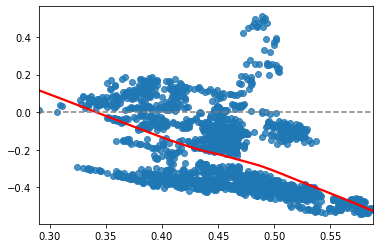

In [19]:
sns.regplot(fitted, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([fitted.min(), fitted.max()], [0, 0], '--', color='grey')

In [20]:
## 잔차의 정규성
## 잔차가 정규분포를 따른 다는 가정
## Q-Q플롯으로 확인할 수 있음
## 잔차가 정규분포를 띄면 Q-Q 플롯에서 점들이 점선을 따라 배치되어야함

import scipy.stats

In [21]:
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)

C:\Users\user\anaconda3\envs\py38_64\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


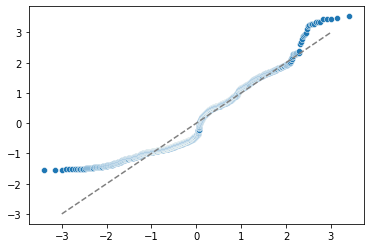

In [22]:
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

In [23]:
scipy.stats.shapiro(residual)

ShapiroResult(statistic=0.9267740845680237, pvalue=3.2130718082551436e-30)

C:\Users\user\anaconda3\envs\py38_64\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


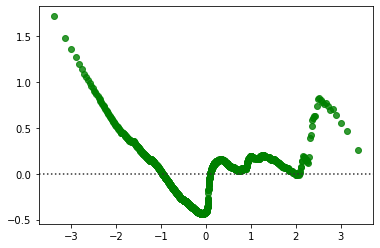

In [24]:
sns.residplot(x,y, color = "g")

In [25]:
## 잔차의 등분산성
## 회귀모형을 통햬 예측된 값이 크던 작던, 모든 값들에 대하여 잔차의 분산이 동일하다는 가정
## 아래 그래프는 예측값(가로축)에 따라 잔차가 어떻게 달라지는지 보여줌
## 빨간색 실선이 수평선을 그리는 것이 이상적

In [26]:
import numpy as np

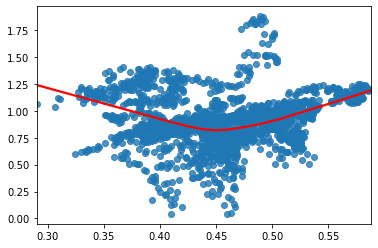

In [27]:
sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

In [28]:
## 극단값
## Cook's distance는 극단값을 나타내는 지표

In [29]:
from statsmodels.stats.outliers_influence import OLSInfluence

In [30]:
cd, _ = OLSInfluence(res).cooks_distance

In [31]:
cd.sort_values(ascending=False).head()

2020-05-15    0.002318
2020-05-29    0.002310
2020-05-22    0.002306
2020-05-14    0.002253
2020-03-23    0.002244
dtype: float64

In [32]:
Y = output['Close']
X = output.drop(['Close'], axis=1).shift(-2).fillna(output.mean())


In [33]:
from sklearn.model_selection import train_test_split

In [34]:
seed = 0
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)

In [35]:
X_train

,US,SNP500,SOXX,SOXS,TREASURY_5Y
2017-08-31,0.466667,0.457766,0.270797,0.005956,0.501209
2017-06-22,0.470463,0.450480,0.261613,0.006726,0.539896
2019-05-16,0.702847,0.606130,0.359373,0.001618,0.694301
2017-02-09,0.531929,0.407481,0.220099,0.010217,0.592746
2020-11-06,0.408011,0.879786,0.746695,0.000033,0.091537
...,...,...,...,...,...
2015-12-15,0.666059,0.296374,0.111430,0.047676,0.527116
2017-08-16,0.494229,0.445234,0.258905,0.006564,0.541278
2019-07-24,0.663022,0.678154,0.448214,0.000891,0.575820
2014-10-14,0.195406,0.226871,0.079073,0.116841,0.406563


In [36]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    print('RMSLE: {0:.4f}'.format(rmsle))
    return rmsle

In [37]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    #if is_expm1 :
        # 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
    #    y_test = np.expm1(y_test)
        # 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
    #   pred = np.expm1(pred)
    
    model_name = model.__class__.__name__
    print('###',model_name,'###')
    #print('###',model.__class__.__name__,'###')
    rmsle(y_test, pred)
    print('\n{0} 학습데이터셋 정확도: {1:.4f}'.format(model_name, model.score(X_train, y_train)))
    #accuracy = accuracy_score(y_test, pred)    
    #print('{0} 테스트셋 정확도: {1:.4f}'.format(model_name, accuracy))   

In [38]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [39]:
# LinearRegression, 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=500)
gbm_model = GradientBoostingRegressor(n_estimators=500)
xgb_model = XGBRegressor(n_estimators=500)
lgbm_model = LGBMRegressor(n_estimators=500)

model_list = [lr_model, rf_model, gbm_model, xgb_model, lgbm_model]
for model in model_list:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.0436

LinearRegression 학습데이터셋 정확도: 0.8948
### RandomForestRegressor ###
RMSLE: 0.0139

RandomForestRegressor 학습데이터셋 정확도: 0.9984
### GradientBoostingRegressor ###
RMSLE: 0.0148

GradientBoostingRegressor 학습데이터셋 정확도: 0.9977
### XGBRegressor ###
RMSLE: 0.0144

XGBRegressor 학습데이터셋 정확도: 0.9999
### LGBMRegressor ###
RMSLE: 0.0138

LGBMRegressor 학습데이터셋 정확도: 0.9992


In [43]:
model = RandomForestRegressor(n_estimators=500)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

In [44]:
# Make a prediction
predict_prices = model.predict(X_test)

In [48]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

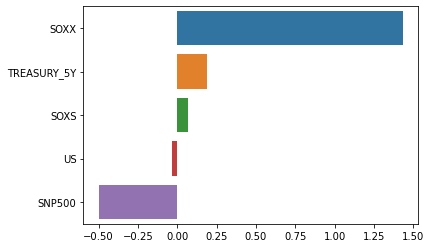

In [49]:
import seaborn as sns
def plotFeatureList(model, X):
    coef = pd.Series(model.coef_, index=X.columns)
    coef_sort = coef.sort_values(ascending=False)
    sns.barplot(x=coef_sort.values, y=coef_sort.index)

plotFeatureList(lr_model, X_train)

In [50]:
df_y_test = pd.DataFrame(y_test, columns=['Close'])

In [51]:
#pd.concat((df_y_test, pd.DataFrame(predict_prices)), axis=1)
df_y_test['predict_prices'] = '0'

In [52]:
for i in range(0,len(predict_prices)):
    df_y_test['predict_prices'][i] = predict_prices[i]

<ipython-input-52-eb7c0015ac3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_test['predict_prices'][i] = predict_prices[i]


In [53]:
df_y_test = df_y_test.sort_index()

In [54]:
df_y_test =df_y_test.apply(pd.to_numeric)

In [55]:
df_y_test

,Close,predict_prices
2012-05-02,0.098478,0.082632
2012-05-07,0.078955,0.072987
2012-05-08,0.078668,0.075860
2012-05-09,0.075797,0.069117
2012-05-14,0.070916,0.051705
...,...,...
2020-12-01,0.666954,0.703098
2020-12-15,0.753086,0.766279
2020-12-30,0.856446,0.821286
2021-01-07,0.883721,0.975894


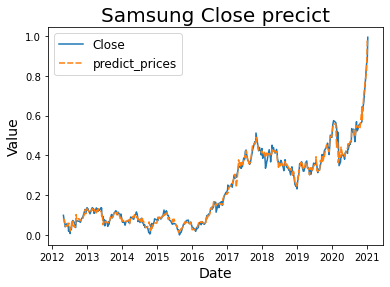

In [56]:
ax = sns.lineplot(data=df_y_test[['Close','predict_prices']])

plt.title('Samsung Close precict', fontsize=20)
plt.ylabel('Value', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()